In [57]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

### Analyzing Emotional Arcs in Paths

This notebook aims to analyze emotional arcs in a dataset of paths. Each path consists of a series of sentiment scores representing emotional states over a Wikispeedia path. We categorize each path into one of five categories: positive to negative, negative to positive, positive to positive, negative to negative and mixed emotions.


In [46]:
def analyze_emotional_arcs(data, threshold=0):
    """
    Analyze emotional arcs in the given dataset with a threshold to determine sentiment.
    
    Parameters:
    data (list of lists): Each sublist represents a path with sentiment scores.
    threshold (float): The value used to determine the sentiment threshold.
    
    Returns:
    dict: A dictionary with analysis results, including common patterns in emotional arcs.
    """
    analysis_results = {
        'positive_to_negative': 0,
        'negative_to_positive': 0,
        'positive_to_positive': 0,
        'negative_to_negative': 0,
        'mixed_emotions': 0
    }
    
    for path in data:
        if len(path) < 3:
            analysis_results['mixed_emotions'] += 1
            continue

        third = len(path) // 3
        start_third_avg = sum(path[:third]) / third
        middle_third_avg = sum(path[third:-third]) / (len(path) - 2 * third) if len(path) - 2 * third > 0 else 0
        end_third_avg = sum(path[-third:]) / third
        
        if start_third_avg > threshold and end_third_avg < -threshold:
            analysis_results['positive_to_negative'] += 1
        elif start_third_avg < -threshold and end_third_avg > threshold:
            analysis_results['negative_to_positive'] += 1     
        elif start_third_avg > threshold and end_third_avg > threshold:
            analysis_results['positive_to_positive'] += 1
        elif start_third_avg < -threshold and end_third_avg < -threshold:
            analysis_results['negative_to_negative'] += 1
        else:
            analysis_results['mixed_emotions'] += 1

    return analysis_results


After defining the function, all the necessary data have to be imported in the notebook.

In [72]:
with open('df_paths_direct.pickle', 'rb') as file:
    df_paths = pickle.load(file)
    
df_paths = df_paths[pd.isna(df_paths['Target score'])] # For this analysis we consider only the succesful paths
df_paths.head()

,Scores,Rounded,Target score
0,"[-0.14721301536458237, -0.028293290087380706, ...","[0, 0, 0, 0, 0, 0, 0, -1, -1]",NaN
1,"[-0.14721301536458237, -0.048477304979667915, ...","[0, 0, 0, -1, -1]",NaN
2,"[-0.14721301536458237, -0.052448976123087784, ...","[0, 0, -1, 0, -1, 0, -1, -1]",NaN
3,"[-0.14721301536458237, 0.037461097698424525, -...","[0, 0, 0, 0]",NaN
4,"[-0.14721301536458237, -0.06396592637112342, 0...","[0, 0, 0, -1, 0, 0, 0]",NaN


Upon defining the function and importing the patterns, the initial step in our analysis should involve quantifying the diversity of prevalent trends observed.

positive_to_negative: 25.4141%
negative_to_positive: 21.1544%
positive_to_positive: 12.9000%
negative_to_negative: 38.9123%
mixed_emotions: 1.6193%


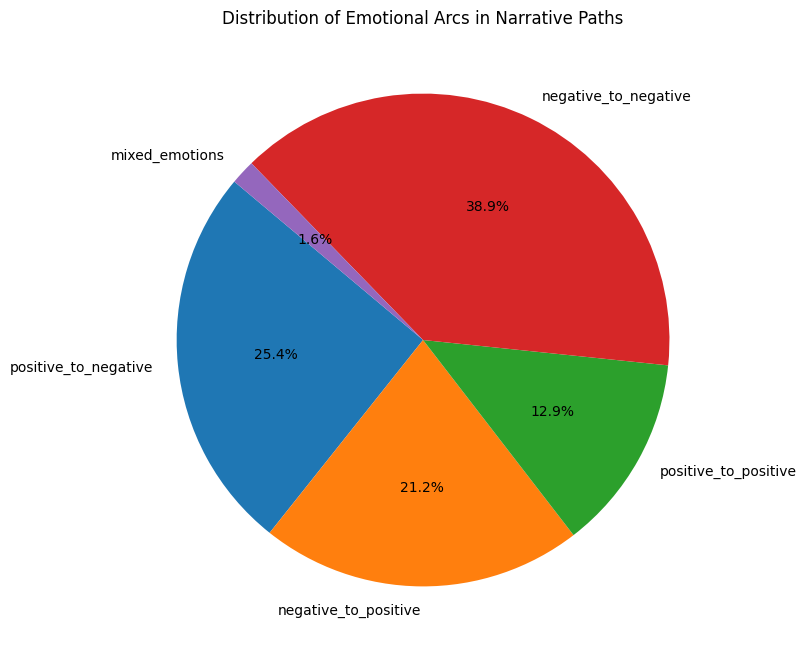

In [74]:
emotional_arcs_analysis = analyze_emotional_arcs(df_paths['Scores'])
total_paths = sum(emotional_arcs_analysis.values())
emotional_arcs_proportions = {arc: count / total_paths for arc, count in emotional_arcs_analysis.items()}
categories = []
percentages = []
for arc, proportion in emotional_arcs_proportions.items():
    categories.append(arc)
    percentages.append(proportion*100)
    print(f"{arc}: {proportion*100:.4f}%")

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotional Arcs in Narrative Paths')
plt.show()

- Only 1.6% of paths exhibits mixed emotions, indicating a complex emotional journey rather than an easily identifiable path.
- A fairly large number of paths show a transition from positive to negative emotions, while the opposite appear to be slightly less frequent. 
- U-shaped emotional arcs oscillating from positive to positive are far more uncommon than negative to negative, and represent respectively the smallest (besides mixed emotions) and biggest trends.

To address concerns about the binary classification of paths as purely positive or negative based on their average score, we can refine our approach by introducing a threshold for neutral paths. Specifically, paths with scores ranging between -0.1 and 0.1 would be classified as neutral. This adjustment offers a more nuanced and realistic representation of the data, acknowledging paths that don't strongly lean towards either extreme of sentiment, but most offen show neutral values.

positive_to_negative: 3.2016%
negative_to_positive: 2.8606%
positive_to_positive: 1.4634%
negative_to_negative: 7.2840%
mixed_emotions: 85.1904%


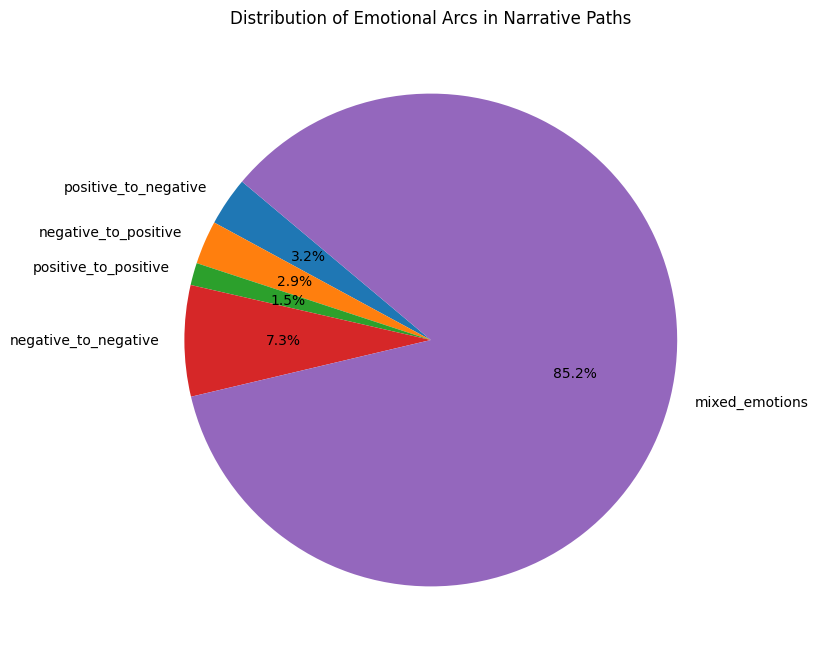

In [87]:
emotional_arcs_analysis = analyze_emotional_arcs(df_paths['Scores'], threshold=0.1)
total_paths = sum(emotional_arcs_analysis.values())
emotional_arcs_proportions = {arc: count / total_paths for arc, count in emotional_arcs_analysis.items()}
categories = []
percentages = []
for arc, proportion in emotional_arcs_proportions.items():
    categories.append(arc)
    percentages.append(proportion*100)
    print(f"{arc}: {proportion*100:.4f}%")

plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotional Arcs in Narrative Paths')
plt.show()

After applying the threshold, we observed that the overall trend remains consistent, yet there's a significant increase in the paths classified as mixed emotions. 

This observation suggests that our current analysis, highly sensitive to the chosen threshold value, might not be the most effective for studying pattern trends. It indicates the need for more robust statistical methods to accurately discern and analyze trends in the data. 

## Clustering

To facilitate the analysis of the patterns, it's advantageous to split them into three distinct and easily identifiable values, that is, the mean value of the beginning, the middle and the end of the paths. This categorization simplifies the means to perform further comparison and enhances the interpretability of results.

In [6]:
def split_list(lst):
    n = len(lst)
    size = n // 3
    remainder = n % 3
    indices = [0 + size * i + min(i, remainder) for i in range(4)]
    return [lst[indices[i]:indices[i + 1]] for i in range(3)]

# Divide the paths into three parts and remove the ones with length inferior to 3
df_paths['Split_Scores'] = df_paths['Scores'].apply(lambda x: split_list(x) if len(x) >= 3 else np.NaN)
data = df_paths['Split_Scores'].dropna().to_list()

In [50]:
mean_list = []
for i, sublist in enumerate(data):
    new_list = []
    for list in sublist:
        mean = np.mean(list)
        new_list.append(mean)
    mean_list.append(new_list)
    if i <= 5:
        print(new_list) # Print the first 5 lists to show the intermediate result

[-0.05701372331580512, 0.02285048508252055, -0.5790338682112557]
[-0.09784516017212513, -0.4750232424984818, -0.7870551196368035]
[-0.3156218438435746, -0.35942066050603594, -0.818829315600258]
[-0.05487595883307892, -0.05476150467499277, 0.0806443166846585]
[-0.05895270712643638, -0.49519910992416655, -0.03754376001933862]
[-0.09784516017212513, -0.0016815061165783643, -0.03754376001933862]


To enhance our comprehension of the prevalent trends in Wikispeedia patterns, performing clustering can be a good idea. This technique excels in neatly segmenting complex data into distinct groups based on similarities, thereby spotlighting the most common behavioral patterns.

In [51]:
import warnings
warnings.filterwarnings("ignore") # Ignore warnings it the code below to improve readability

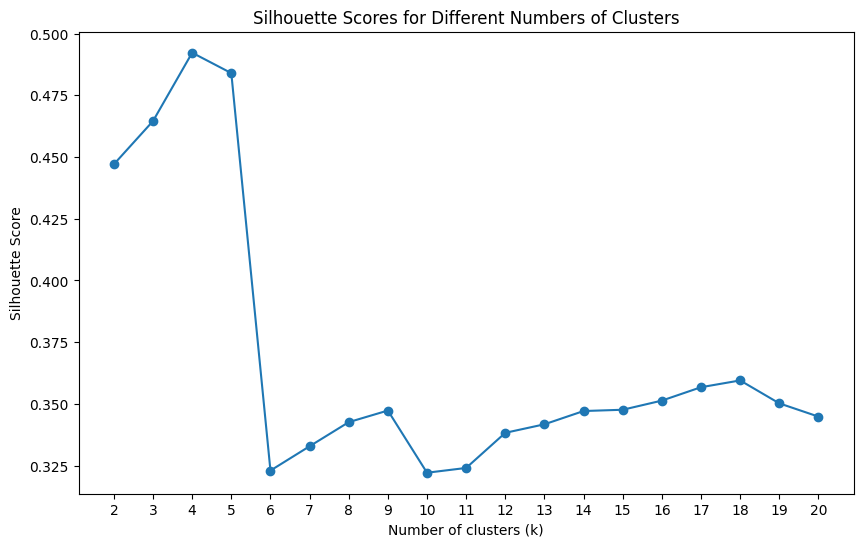

In [53]:
features = np.array([[lst[i+1] - lst[i] for i in range(len(lst)-1)] for lst in mean_list])

k_range = range(2, 21) 

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    score = silhouette_score(features, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(k_range)
plt.show()

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

k = silhouette_scores.index(max(silhouette_scores)) + 2 # Get the number of clusters with the highest silhouette score
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(features_normalized)


The silhouette score analysis of the data conclusively indicates that four clusters are sufficient to encapsulate the key variations in path trends, providing a clear and efficient segmentation for understanding the essential differences.

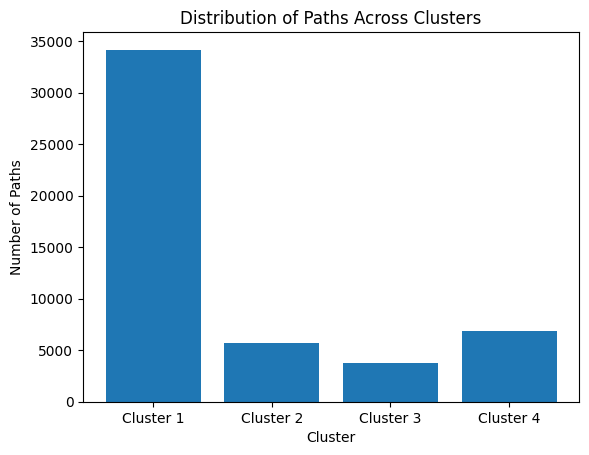

In [103]:
frequencies = []
for i in range(k):
    count = 0
    for j, lst in enumerate(data):
        if clusters[j] == i:
            count += 1
    frequencies.append(count)

cluster_labels = [f'Cluster {i+1}' for i in range(k)]
plt.bar(cluster_labels, frequencies)
plt.xlabel('Cluster')
plt.ylabel('Number of Paths')
plt.title('Distribution of Paths Across Clusters')
plt.show()
            

A pie chart can provide a more visually intuitive and immediate understanding of the data.

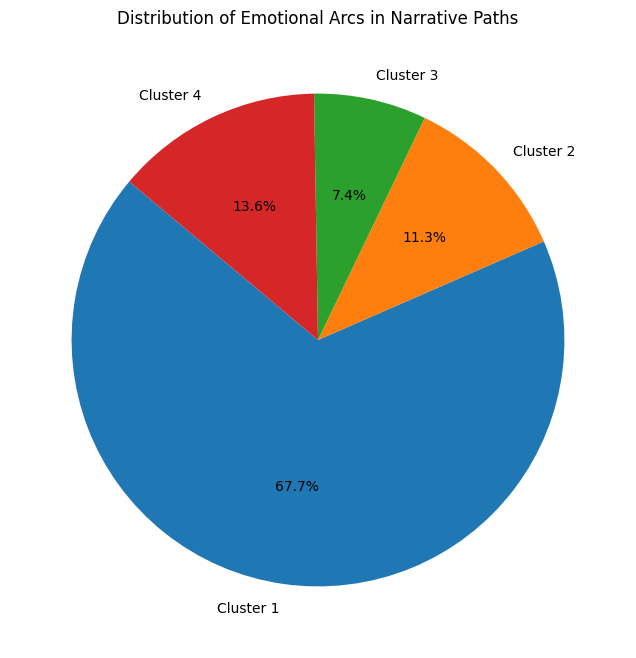

In [104]:
percentages = [frequency / len(data) * 100 for frequency in frequencies]
cluster_labels = [f'Cluster {i+1}' for i in range(k)]
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=cluster_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotional Arcs in Narrative Paths')
plt.show()
           

In the first cluster, the vast majority of the paths are grouped, indicating that this cluster represents the most dominant pattern in the dataset. The second and fourth clusters contain a considerable but notably smaller number of paths compared to the first, suggesting that while these patterns are significant, they are less prevalent, while the third cluster shows to contain the fewest paths.

In [138]:
mean_clusters = []
for i in range(k):
    new_list = []
    for j, lst in enumerate(data):
        if clusters[j] == i:
            new_list.append([sum(sublist) / len(sublist) for sublist in lst])
    cluster_mean = [sum(values) / len(new_list) for values in zip(*new_list)]
    mean_clusters.append(cluster_mean)
mean_clusters

[[-0.016579378921010173, -0.03267919486477002, -0.03359431423265522],
 [0.0319312770988049, -0.3851217319980016, -0.008419282199169627],
 [-0.3402031043316248, 0.08283902570681093, 0.01449662379523455],
 [-0.03159900878821033, -0.06693447716031418, -0.6664092053147421]]

In order to effectively visualize and understand the trends represented by these clusters, a graphical representation of the average values of these clusters is indeed more suited.

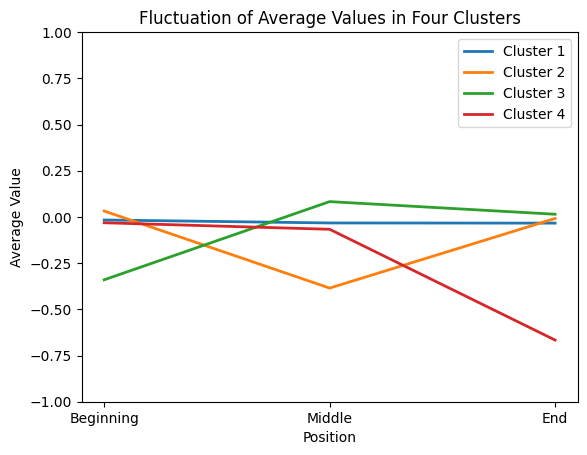

In [134]:
for i, cluster in enumerate(mean_clusters):
    plt.plot(['Beginning', 'Middle', 'End'], cluster, label=f'Cluster {i+1}', linewidth=2.0)

plt.xlabel('Position')
plt.ylabel('Average Value')
plt.title('Fluctuation of Average Values in Four Clusters')
plt.ylim(-1, 1)
plt.legend()
plt.show()

This plot illustrates the predominant trends identified in our pattern analysis. The first cluster, representing the most common trend, follows a consistent trajectory with a near-zero value, aligning with our expectations of a stable, neutral sentiment. The second trend showcases a U-shaped pattern, beginning and ending with neutral sentiment but dipping into negative territory in the middle. This suggests a tendency for neutral articles to briefly adopt a more negative tone before returning to neutrality. The third and fourth clusters, though less common, exhibit distinct characteristics: the third starts negatively before transitioning to neutrality, while the fourth does the opposite, ending on a particularly negative note after a neutral start. This may suggest that neither negative nor positive scores are consistently found throughout the whole length of the path, but instead they are usually singular outliers or few neighbors. 

The noticeable absence of positive sentiment peaks across all clusters indicates that the algorithm employed for sentiment analysis tends to identify more negative sentiments. This bias towards negativity could likely be attributed to the structural and stylistic elements of Wikipedia articles. Such articles, often factual and objective in nature, may inherently contain language that the algorithm interprets more easily as negative rather than positive. 

Our analysis revealed an intriguing trend: articles at the end of the paths tend to have lower sentiment scores. This pattern could be attributed to a strategic approach by users when navigating towards a negatively perceived final article. For instance, if a user aims to reach an article like 'Adolf Hitler', he is more likely to traverse through similarly negative subjects such as 'World War Two' or 'Holocaust' near the end of their journey. These subjects, often closely linked in context, form a logical progression towards the intended negative outcome, and can therefore explain why negative articles are more likely to cluster at the end of the path. Conversely, we observed that negatively perceived topics tend not to cluster at the beginning or middle of a search. For instance, in a user's quest to find 'Mercedes Benz', an article like 'Adolf Hitler' might be selected in anticipation of its connection to 'Germany,' but this doesn't typically initiate a sequence of negative articles, suggesting that while negative topics might serve as stepping stones due to their contextual links, they don't usually set the overall tone of the search journey. This observation highlights a nuanced aspect of user navigation behavior, particularly in how sentiment perceptions influence the structuring of their search paths.


In [34]:
negative_end = cluster[2]
size_cluster = 0
count = 0
for j, lst in enumerate(data):
    if clusters[j] == 2:
        size_cluster += 1
        if lst[-1][-1] < -0.5:
            count += 1

print(f'Percentage of path with negative goal article in cluster 3: {count/size_cluster*100:.2f}%')

Percentage of path with negative goal article in cluster 3: 83.27%


To validate our hypothesis, we quantitatively assessed the paths in the fourth cluster, focusing on those with a negatively perceived end goal (defined as articles with a sentiment score below -0.5). The resulting statistic is striking: 83.27% of the paths in this cluster indeed had a negative target article. This significant majority reinforces our hypothesis, confirming that most narratives within this cluster are directed towards a negative endpoint., explaining also why the average sentiment scores are lower in this cluster compared to the other three.  